# A quick start on using plag package

plag is written in python/cpython. The base calculations are done in cpython (_plag.pyx) to make it fast. A python wrapper (plag.py) is used to manage the calls.

The files are not well documented yet.
This tutorial walks through a simple example of calculating the psd and lags between two light curves in the file named data.lc in the current directory.

---------------------------------------------


* We import numpy and our plag packages.
* We call pylab to help with plotting.
* We then read the light curve data. The file has 5 columns: time, lc1, lc1e , lc2, lc2e. These are simulated light curves with a high signal and no gaps to illustrate the general use of the package.
* The light curves are then plotted.


Populating the interactive namespace from numpy and matplotlib


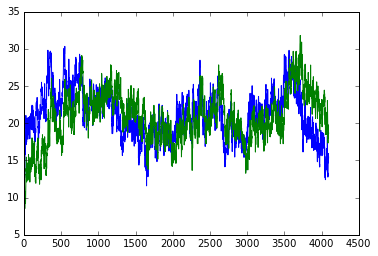

In [29]:
import numpy as np
import plag

## for plotting ##
%pylab inline

### read the light curve ###
data = np.loadtxt('data.lc')
dt = data[1,0] - data[0, 0]

_ = plot(data[:,0], data[:,1])
_ = plot(data[:,0], data[:,3])

# Prepare the data
Because the light curves are long, we split them to segments of length seg_length=256, and then create a list of segments to be passed to the clag initializer.

In [30]:
# Split the light curve into segments #
seg_length = 256
index = np.arange(len(data)).reshape((-1, seg_length))

T = [data[i, 0] for i in index]
Lc1  = [data[i, 1] for i in index]
Lc1e = [data[i, 2] for i in index]
Lc2  = [data[i, 3] for i in index]
Lc2e = [data[i, 4] for i in index]


* We now define the frequency bins to be used for the psd and cross spectrum calculations.


In [31]:
#### Get the psd for the first light curve ####

# frequency bins #
fqL = np.logspace(np.log10(1.1/seg_length),np.log10(.5/dt),7)
fqL = np.concatenate(([0.5/seg_length], fqL))
nfq = len(fqL) - 1


# Calculate the psd of the first light curve

When modeling a single light curve, we can use `plag.psd` or `plag.lag`. When modeling multiple light curves at the same time, use `plag.PLag('psd',...)` and `plag.PLag('lag', ..)`
 
The rest of parameters depend on the class used. To see the parameters do `plag.psd?` for documentation

`plag.PLag` is more general so we use it.


To calculate the psd, we need a list of arrays `T` for the light curve times, `Lc1`, for the light curve rates, and `Lc1e` for the light curve measurement errors, then `dt`, the time bin of the data (i.e. exposure time), and `fqL`: a list of the frequency boundaries for the bins to be fitted

In [32]:
## initialize the psd class for multiple light curves ##
## the default normalization is rms units ##
P1  = plag.PLag('psd', T, Lc1, Lc1e, dt, fqL)


`inpars` is a starting array holding the input psd values at the chosen frequency bins, this should have a length `len(fqL)-1`.
We then print the log likelihood at these input values as a test that things are ok.

In [33]:
## initial parameters, start with ones
inpars = np.ones(nfq)

## print the loglikelihood for the input values ##
print(P1.logLikelihood(inpars))

-20766.7467472



We now do the fitting using `plag.optimize`, which takes as arguments, the class we just defined, and the input array (plus other arguments to control the fit). This uses a quadratic approximation to the likelihood, and loops until a best fit value is found. The result is returned as a tuple of best fit values, psd1, and their ESTIMATED error psd1e taken from the hessian of the likelihood function. This estimate is generally a lower limit only, and MCMC chains are needed to get the full errors.

The progress is printed with each line showing:
* iteration number.
* maximum absolute change in the parameters in current iteration (absmax).
* maximum absolute gradient at current location (gmax).
* the loglikelihood value.
* a list of fitted parameters

Then once `absmax` or `gmax` is below the tolerance level passed to optimize (default 1e-4), or number of iterations exeeds a maximum (default 500), the function prints:
* current parameters
* their estimated errors.
* the gradient at current location
The fit is valid if the gradients are close to zero.

In [34]:
## Now do the fitting and find the best fit psd values at the given frequency bins ##
psd1, psd1e = plag.optimize(P1, inpars)

   1 4.466e+02 5.510e+03 inf -- -2.077e+04 -- 1 1 1 1 1 1 1
   2 2.156e-01 3.890e+01 1.594e+04 -- -4.831e+03 -- 447.65 197.72 59.326 23.6258 5.708 1.79856 0.689895
   3 2.356e-02 6.354e-02 1.712e+00 -- -4.829e+03 -- 544.148 192.607 59.8723 21.1887 5.54487 1.73612 0.671665
   4 2.883e-03 2.918e-03 6.352e-03 -- -4.829e+03 -- 556.97 193.207 59.8523 21.1068 5.53967 1.73617 0.671694
   5 3.822e-04 3.719e-04 9.076e-05 -- -4.829e+03 -- 558.576 193.263 59.8235 21.1019 5.53928 1.73617 0.671693
********************
558.576 193.263 59.8235 21.1019 5.53928 1.73617 0.671693
136.107 10 9.32986 2.13858 0.375107 0.0790134 0.0211839
1.14419e-05 6.48102e-06 -7.15781e-05 -7.25802e-05 -0.000234608 -0.000159413 -0.000371948
********************


# Plot the result of the psd fit

<Container object of 3 artists>

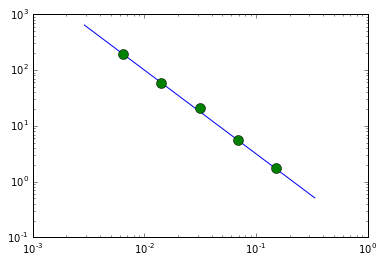

In [35]:
## plot ##
fqd = 10**(np.log10( (fqL[:-1]*fqL[1:]) )/2.)

loglog(fqd, 0.1*fqd**(-1.5), label='input psd')
errorbar(fqd[1:-1], psd1[1:-1], yerr=psd1e[1:-1], fmt='o', ms=10, label='fit')

In [16]:

## Now do the second light curve

P2  = plag.PLag('psd', T, Lc2, Lc2e, dt, fqL)

psd2, psd2e = clag.optimize(P2, inpars)


   1 3.209e+02 4.473e+03 inf -- -1.951e+04 -- 1 1 1 1 1 1 1
   2 2.149e-01 3.308e+01 1.468e+04 -- -4.824e+03 -- 321.904 226.369 58.9332 23.2201 5.73063 1.79719 0.680492
   3 3.297e-02 7.245e-02 1.341e+00 -- -4.823e+03 -- 391.092 214.942 60.6903 20.8544 5.57654 1.76492 0.665351
   4 6.307e-03 1.337e-03 1.049e-02 -- -4.823e+03 -- 403.985 213.446 60.4228 20.8267 5.57309 1.76495 0.665383
   5 1.299e-03 2.276e-04 4.305e-04 -- -4.823e+03 -- 406.533 213.115 60.3338 20.8259 5.57291 1.76496 0.665383
   6 7.001e-05 4.784e-05 1.869e-05 -- -4.823e+03 -- 407.061 213.045 60.3143 20.8259 5.57288 1.76496 0.665383
********************
407.061 213.045 60.3143 20.8259 5.57288 1.76496 0.665383
10 10 9.39487 10 0.377197 0.080288 10
9.91518e-06 -4.04952e-06 -4.78438e-05 -7.71374e-06 -3.72828e-05 4.34726e-05 -3.23287e-06
********************


In [17]:
### Now the cross spectrum ###
### We also give it the calculated psd values as input ###
Cx = plag.PLag('lag', 
               [list(i) for i in zip(T,T)], 
               [list(i) for i in zip(Lc1,Lc2)],
               [list(i) for i in zip(Lc1e,Lc2e)], 
               dt, fqL, psd1, psd2)

inpars = np.concatenate( (0.3*(psd1*psd2)**0.5, psd1*0+1.) )
p, pe = clag.optimize(Cx, inpars)
phi, phie = p[nfq:], pe[nfq:]
lag, lage = phi/(2*np.pi*fqd), phie/(2*np.pi*fqd)
cx, cxe   = p[:nfq], pe[:nfq]

   1 2.328e+00 1.749e+03 inf -- -8.763e+03 -- 143.051 60.8739 18.0205 6.28904 1.66682 0.525152 0.200559 1 1 1 1 1 1 1
   2 1.042e+01 1.672e+03 3.379e+03 -- -5.384e+03 -- 249.98 193.608 59.5574 20.9046 5.54789 1.73941 0.503299 -0.0343698 0.816594 0.923578 1.02812 0.991901 0.967044 0.451682
   3 5.903e-01 8.530e+02 2.730e+02 -- -5.111e+03 -- 228.398 199.138 59.9075 20.9544 5.554 1.73856 0.489617 0.323769 0.989329 0.991401 1.00313 0.998086 0.99099 0.795839
   4 4.193e-01 3.000e+02 8.294e+01 -- -5.028e+03 -- 249.061 202.456 60.0618 20.962 5.55402 1.73902 0.520802 0.132661 0.993959 0.998126 1.00168 0.998076 0.99063 0.791744
   5 2.783e-02 1.231e+01 2.074e+00 -- -5.026e+03 -- 257.337 202.587 60.0693 20.9619 5.55387 1.73904 0.522044 0.188288 0.995546 0.998487 1.00111 0.99788 0.990512 0.793835
   6 7.215e-03 1.008e+00 4.220e-03 -- -5.026e+03 -- 259.102 202.591 60.0692 20.962 5.55386 1.73904 0.522124 0.183048 0.996202 0.998515 1.00104 0.997835 0.990504 0.793919
   7 2.124e-03 2.060e-01 1.082e-0

<Container object of 3 artists>

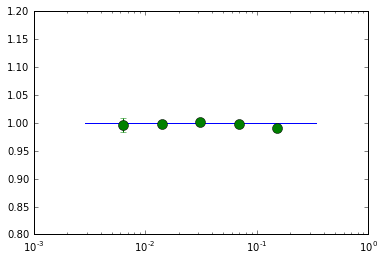

In [22]:
## plot ##

semilogx(fqd, fqd*0+1.0, label='input phase lag')
ylim([0.8, 1.2])
errorbar(fqd[1:-1], phi[1:-1], yerr=phie[1:-1], fmt='o', ms=10, label='fit')
